In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.dataloader import default_collate
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(1)

In [4]:
tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(232),
    transforms.RandomAffine(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

In [5]:
db = torchvision.datasets.ImageFolder(root='cats', transform=tf)

In [6]:
print(db.class_to_idx)

{'lastik': 0, 'other': 1}


In [7]:
batch_size = 256
output_shape = 2
loader = torch.utils.data.DataLoader(db, batch_size=batch_size, shuffle=True)
classes = ('lastik', 'other')

In [8]:
train_set, test_set = torch.utils.data.random_split(db, [0.7, 0.3], generator=torch.Generator().manual_seed(1))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                           collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True,
                                          collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_len = len(test_set)

c:\Soft\Anaconda\lib\site-packages\PIL\JpegImagePlugin.py:812: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


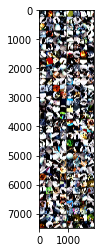

other other lastik other lastik other other lastik lastik other lastik other lastik lastik other lastik other lastik lastik lastik lastik other lastik lastik other other other lastik lastik lastik lastik lastik lastik other lastik lastik lastik lastik lastik lastik lastik other lastik lastik lastik other lastik lastik lastik other lastik other other lastik lastik other other lastik other other other other lastik other other other lastik lastik lastik other lastik lastik lastik lastik other lastik lastik other lastik other other other lastik lastik other other lastik other other other other other lastik lastik other lastik lastik lastik lastik other lastik other lastik lastik lastik lastik other lastik other other lastik lastik lastik lastik lastik lastik lastik other lastik other lastik lastik lastik other lastik lastik other lastik other other other lastik other lastik other other lastik lastik other lastik other other lastik other lastik lastik lastik lastik other lastik other lastik

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img  / 2  + 0.5    
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
fc_inputs = model.fc.in_features

In [11]:
for i, param in enumerate(model.parameters()):
    param.requires_grad = False

In [12]:
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, output_shape), 
)

In [13]:
from torchinfo import summary
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

C:\Users\ioci\AppData\Roaming\Python\Python39\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
C:\Users\ioci\AppData\Roaming\Python\Python39\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [14]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

In [22]:
for epoch in range(4): 
    running_loss = 0.0
    for j, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if j % 2 == 1: 
            print(f'[{epoch + 1}, {j + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
print('Finished Training')

# path = './cats_net_resnet50.pth'
# print(path)
# torch.save(model.state_dict(), path)

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images)

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {test_len} test images: {100 * correct // total} %')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

param_count = get_n_params(model)
print(f'Model size: {param_count} parametres')

[1,     2] loss: 0.028
[1,     4] loss: 0.027
[2,     2] loss: 0.026
[2,     4] loss: 0.027
[3,     2] loss: 0.025
[3,     4] loss: 0.019
[4,     2] loss: 0.019
[4,     4] loss: 0.016
Finished Training
Accuracy of the network on the 464 test images: 96 %
Accuracy for class: lastik is 96.5 %
Accuracy for class: other is 98.3 %
Model size: 24820802 parametres


In [23]:
from PIL import Image
def image_loader(image_name):
    tf_eval = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(232),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])
    image = Image.open(image_name)
    image = tf_eval(image).unsqueeze(0)
    return image

(<matplotlib.image.AxesImage at 0x15686307e20>, ([], []), ([], []))

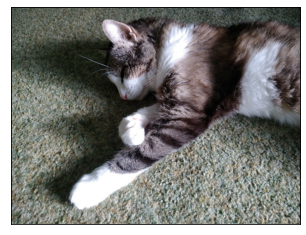

In [24]:
plt.imshow(Image.open('./lastik_example.jpg')), plt.xticks([]), plt.yticks([])

In [25]:
image = image_loader('./lastik_example.jpg')

In [26]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
def pre_image(image, model, classes):
   with torch.no_grad():
      model.eval()  
      output = model(image)
      index = output.data.cpu().numpy().argmax()
      class_name = classes[index]
      return class_name

In [27]:
print(f"Resnet50 says it's {pre_image(image.to(device), model, db.classes)}")

Resnet50 says it's lastik
